# Spectral analysis
- Load data
- Preprocess
    - Resample down to 3kHz
    - Notch line noise and harmonics
    - Reference CAR
    - Compute wavelet transform
    - Resample down to 400Hz
- Plot spectrogram for one channel

In [21]:
from laminar_uecog_viz import spectral
from process_nwb import resample, linenoise_notch, common_referencing, wavelet_transform
from nsds_lab_to_nwb.tools.tdt.tdt_reader import TDTReader
import pandas as pd
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from laminar_uecog_viz import get_zscore as gz
from laminar_uecog_viz import utils 

In [4]:
# Plotting parameters
mpl.rcParams['figure.facecolor'] = '1'

## User defined parameters

In [5]:
data_path = '/Users/vanessagutierrez/data/Rat/RVG14/RVG14_B03' #path where TDT data lives
data_dump_path = os.path.join(data_path, 'preprocessed') #path to dump preprocessed data
plot_dump_path = os.path.join(data_path, 'plot') #path to save plots

fs = 3200 #intermediate (before wavelet transform) sample rate
fs_final = 400 #final sample rate (after wavelet transform)
num_ch = 1 #change to -1 for all channels

In [6]:

if not os.path.exists(data_dump_path):
    os.mkdir('{}/preprocessed'.format(data_path))

In [7]:

if not os.path.exists(plot_dump_path):
    os.mkdir('{}/plot'.format(data_path))

## Load data

In [8]:
rec = TDTReader(data_path)
data, params = rec.get_data(stream='Wave')
print(data.shape, params)

read from t=0s to t=73.0s
(888832, 128) {'sample_rate': 12207.03125, 'channel_ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128], 'start_time': '12:43:02', 'num_channels': 128, 'num_samples': 888832}


In [10]:
data.shape[1]

128

In [11]:
channel_order = [
                    81, 83, 85, 87, 89, 91, 93, 95, 97, 105, 98, 106, 114, 122, 113, 121,
                    82, 84, 86, 88, 90, 92, 94, 96, 99, 107, 100, 108, 116, 124, 115, 123,
                    66, 68, 70, 72, 74, 76, 78, 80, 101, 109, 102, 110, 118, 126, 117, 125,
                    65, 67, 69, 71, 73, 75, 77, 79, 103, 111, 104, 112, 120, 128, 119, 127,
                    63, 61, 59, 57, 55, 53, 51, 49, 25, 17, 26, 18, 10, 2, 9, 1,
                    64, 62, 60, 58, 56, 54, 52, 50, 27, 19, 28, 20, 12, 4, 11, 3,
                    48, 46, 44, 42, 40, 38, 36, 34, 29, 21, 30, 22, 14, 6, 13, 5,
                    47, 45, 43, 41, 39, 37, 35, 33, 31, 23, 32, 24, 16, 8, 15, 7
                    ]

In [12]:
def channel_orderer(signal_data, channel_order):
    """Puts the wave data into the order of the channels
    Args: 
    data: signal data in timepoints x channels
    chs (list): the correct order of the channels"""
    shape_wanted = signal_data.shape
    new_data = np.empty((shape_wanted[0], shape_wanted[1]))
    
    for i in np.arange(shape_wanted[1]):
        new_data[:, i] = signal_data[:, (channel_order[i] - 1)]
    return new_data

In [13]:
new_data = channel_orderer(data, channel_order)

In [14]:
new_data.shape

(888832, 128)

In [15]:
chs = range(data.shape[1])
chs

range(0, 128)

In [16]:
num_ch = len(chs)
num_ch

128

In [17]:
# Timestamps where stimulus occurs (correct for 0.25s offset)
events = rec.get_events()
events += events + 0.25
print(f'Number of events: {str(len(events))}')

Number of events: 60


## Preprocess

In [19]:
chs = range(data.shape[1])
num_frame = data.shape[0]

# if num_ch < 0:
#     num_ch = len(chs)

data_proc = resample.resample(new_data, fs, params['sample_rate'])
data_proc = linenoise_notch.apply_linenoise_notch(data_proc, fs)
data_proc = common_referencing.subtract_CAR(data_proc)
t = np.arange(0, num_frame)/fs

data_proc_file = os.path.join(data_dump_path, 'data_proc.npy')
np.save(data_proc_file, data_proc)
time_file = os.path.join(data_dump_path, 'time.npy')
np.save(time_file, t)  

In [20]:
data_proc.shape

(233002, 128)

In [82]:
# Calculate wavelet transform
all_ch_wavelets = {}

for ch in np.arange(len(channel_order)):
    t1 = time.time()
    print('Starting wavelet transform')
    W, _, f, _ = wavelet_transform.wavelet_transform(data_proc[:, ch].reshape((-1, 1)), 
                                                     fs, filters='rat', hg_only=False)
    W = np.float32(abs(W))
    W = resample.resample(W, fs_final, fs)
    W = np.squeeze(W, axis=1)
    all_ch_wavelets[channel_order[ch]] = W
    t2 = time.time()
    wavelet_file = os.path.join(data_dump_path, f'wavelet_coefs_ch{str(ch)}.npy')
    np.save(wavelet_file, W)
    print(f'Wavelet compute time: {str(np.round(t2-t1, 2))}s')

print('Done preprocessing')

Starting wavelet transform
Wavelet compute time: 1.36s
Starting wavelet transform
Wavelet compute time: 1.23s
Starting wavelet transform
Wavelet compute time: 1.29s
Starting wavelet transform
Wavelet compute time: 1.37s
Starting wavelet transform
Wavelet compute time: 1.35s
Starting wavelet transform
Wavelet compute time: 1.22s
Starting wavelet transform
Wavelet compute time: 1.45s
Starting wavelet transform
Wavelet compute time: 1.48s
Starting wavelet transform
Wavelet compute time: 1.27s
Starting wavelet transform
Wavelet compute time: 1.24s
Starting wavelet transform
Wavelet compute time: 1.24s
Starting wavelet transform
Wavelet compute time: 1.23s
Starting wavelet transform
Wavelet compute time: 1.21s
Starting wavelet transform
Wavelet compute time: 1.2s
Starting wavelet transform
Wavelet compute time: 1.3s
Starting wavelet transform
Wavelet compute time: 1.3s
Starting wavelet transform
Wavelet compute time: 1.38s
Starting wavelet transform
Wavelet compute time: 1.24s
Starting wave

In [83]:
len(all_ch_wavelets)

128

In [87]:
all_ch_wavelets

{81: array([[8.1508932e+00, 3.3208473e+00, 8.6173306e+00, ..., 1.1395920e-01,
         1.0433196e-01, 9.9574693e-02],
        [8.1356306e+00, 3.2689972e+00, 8.5932169e+00, ..., 2.5336891e-02,
         1.7115906e-02, 1.3917321e-02],
        [8.1206484e+00, 3.2180886e+00, 8.5694084e+00, ..., 9.1642579e-03,
         8.3249100e-03, 5.8944854e-03],
        ...,
        [8.1982441e+00, 3.4816611e+00, 8.6914845e+00, ..., 2.7732391e-02,
         2.8729672e-02, 1.6676910e-02],
        [8.1822004e+00, 3.4272048e+00, 8.6664600e+00, ..., 8.8287508e-03,
         1.8985108e-02, 1.8073609e-02],
        [8.1664152e+00, 3.3735976e+00, 8.6417494e+00, ..., 3.5331622e-02,
         2.9629836e-02, 2.9701222e-02]], dtype=float32),
 83: array([[ 1.0391017e+01,  8.9605484e+00,  1.1626536e+01, ...,
          1.8183434e-01,  1.6678987e-01,  1.5436916e-01],
        [ 1.0343355e+01,  8.8845282e+00,  1.1577138e+01, ...,
          5.0142866e-02,  2.9966652e-02,  2.4724901e-02],
        [ 1.0295871e+01,  8.8088951e+0

In [84]:
all_ch_wavelets[87].shape

(29126, 54)

In [136]:
ch_87 = all_ch_wavelets[87]

In [137]:
ch_87.T

array([[9.07811928e+00, 9.02373695e+00, 8.96958160e+00, ...,
        9.24247360e+00, 9.18749523e+00, 9.13270760e+00],
       [1.02603445e+01, 1.01930857e+01, 1.01263208e+01, ...,
        1.04649134e+01, 1.03962603e+01, 1.03280773e+01],
       [1.33173380e+01, 1.32671862e+01, 1.32173691e+01, ...,
        1.34697638e+01, 1.34186249e+01, 1.33678217e+01],
       ...,
       [1.20288208e-01, 3.66652422e-02, 6.81506563e-03, ...,
        5.63710928e-03, 2.88665458e-03, 3.35487016e-02],
       [1.07710399e-01, 2.45486628e-02, 6.48579234e-03, ...,
        3.80957476e-03, 2.94375443e-03, 2.41697617e-02],
       [9.73156765e-02, 1.53007368e-02, 2.55697337e-03, ...,
        4.76929592e-03, 5.33594331e-03, 2.14444082e-02]], dtype=float32)

In [31]:
W = np.squeeze(W, axis=1)

In [32]:
W.shape

(29126, 54)

In [46]:
type(W)

numpy.ndarray

## Plot spectrogram for a 0.5 sec window

In [92]:
all_Wsnip_norm = {}

for ch in channel_order:
    
    tbeg = int(fs_final*12.60)
    tend = tbeg + int(fs_final*0.5)
    Wsnip = all_ch_wavelets[ch][tbeg:tend, :]
    mean = np.mean(all_ch_wavelets[ch], axis=0)
    sigma = np.std(all_ch_wavelets[ch], axis=0)
    Wsnip_norm = (Wsnip - mean)/sigma
    all_Wsnip_norm[ch] = Wsnip_norm
    
t = np.arange(0, tend-tbeg)/fs_final
#     fig, ax = spectral.plot_spectrogram(Wsnip_norm, f, t, colorbar=True)
#     ax.set_xlabel('Time (sec)')
#     ax.set_ylabel('Frequency (Hz)')

In [95]:
all_Wsnip_norm[80].shape

(200, 54)

In [141]:
def plot_spect_matrix(W, f, t, nrow, ncol, channel_order):
    
#     if device == 'ECoG':
#         axes = utils.ecog_axes(channel_order, xlabel='Time (sec)', ylabel='Frequency (Hz)', plot_type='Spectrogram')
#     elif device == 'Poly':
#         axes = utils.poly_axes(channel_order, xlabel='Time (sec)', ylabel='Frequency (Hz)', plot_type='Spectrogram')
#     else:
#         raise ValueError("`device` must be one of 'ECoG' or 'Poly'")
    figsize = (40, 40)
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    fig.tight_layout()
    idx = 0
    
    chs = channel_order
    
    while idx < (nrow*ncol):
        row, col = idx // ncol, idx % ncol
        ax = axs[row, col]
        spectral.plot_spectrogram(W, f, t, chs[idx], fig = fig, ax = ax)
        idx += 1
        
#     fig.suptitle('Z-Scored Responses Across Channels: {}'.format(animal_block), fontsize = titlesize, y = 1)
#     fig.supylabel('mV', fontsize = labelsize)
#     fig.supxlabel('Time(ms)', fontsize = labelsize)
    
#     for ch, ax in zip(channel_order, axes):
#         spectral.plot_spectrogram(W, f, t, ch, fig = None, ax = ax)
        

AttributeError: 'dict' object has no attribute 'T'

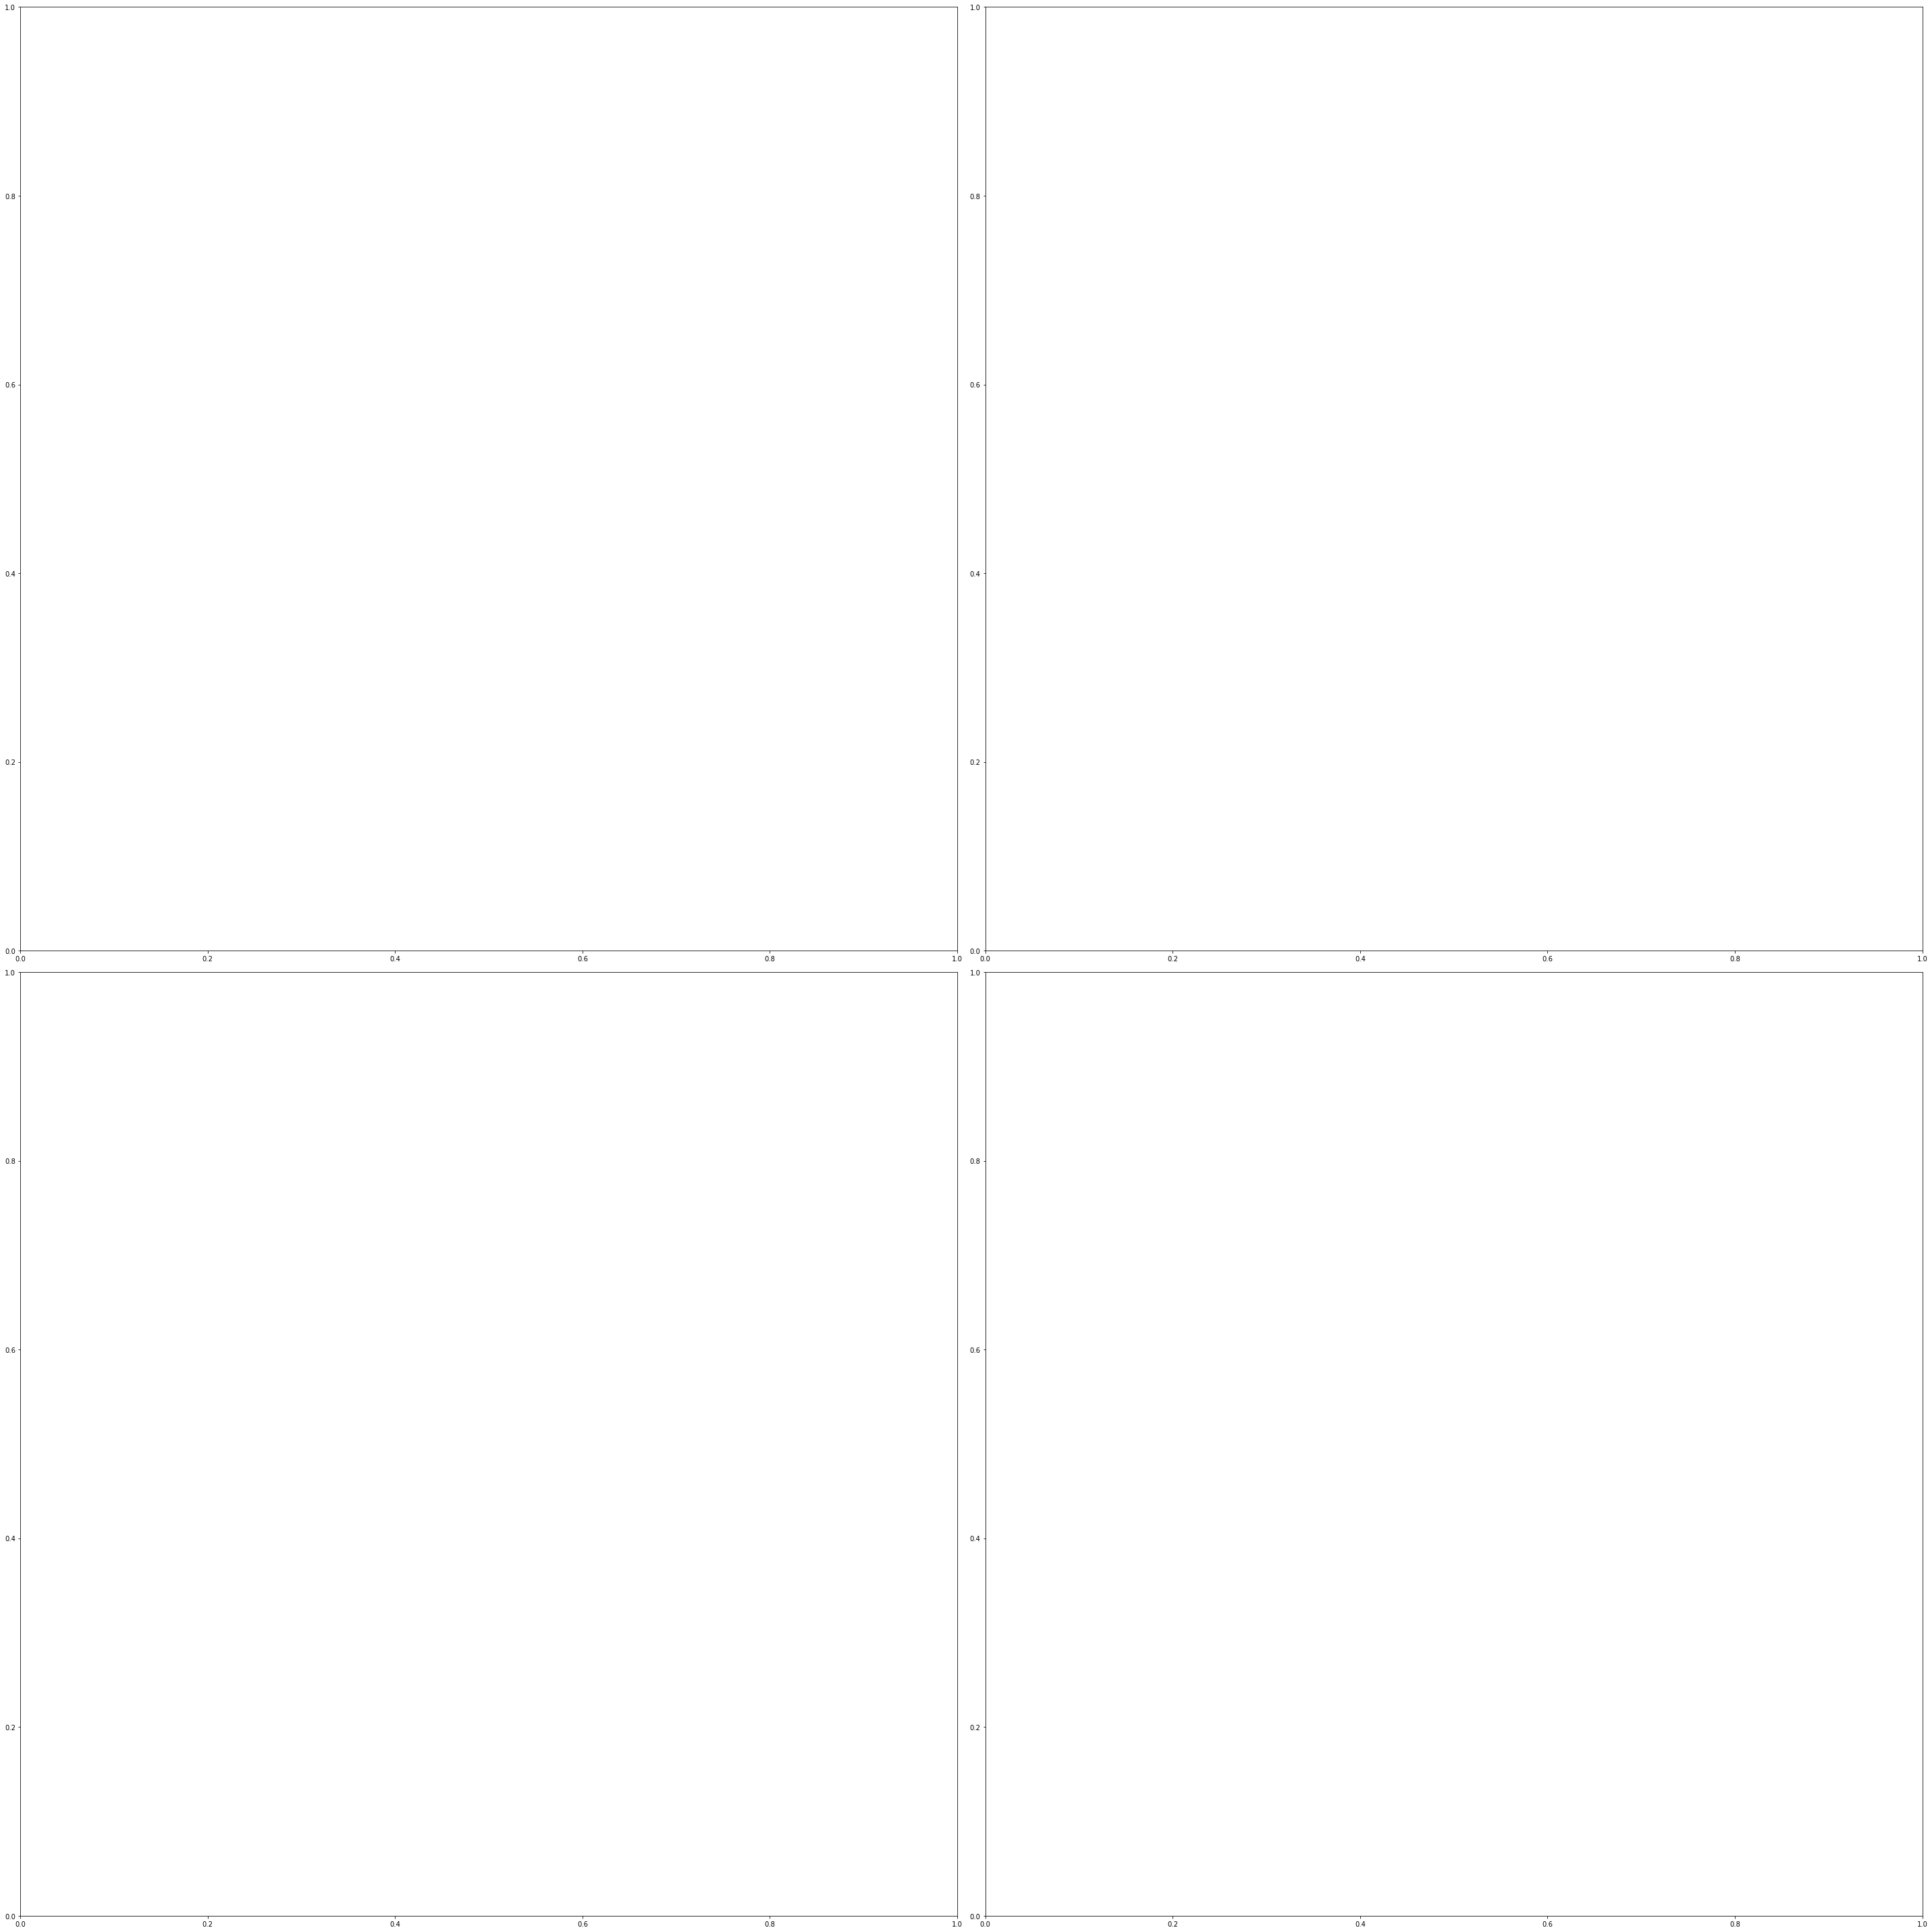

In [142]:
plot_spect_matrix(all_Wsnip_norm, f, t, 2, 2, channel_order)